## Chapter 5

**The Classification Problem**

- A classifier assigns an observation without a known class (aka label) on the the basis of how similar it is to other observations for which we do know the class.

**Distance Between Points**

- The K "nearest" to our new observation is determined by using the straight-line distance:
         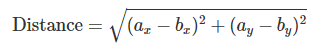

- When there are more than two explanatory variables:
         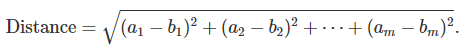

**Summary of K-nearest neighbors algorithm**

- I. Calculate the distance between the new observation and each observation in the training set.
- II. Sort the data table in ascending order of distance.
- III. Choose the top K rows of the sorted table.
- IV. Classify the new observation based on a majority vote of the neighbor classes.

**Data Preprocessing**

- Centering and scaling
  - Since the classifier predicts classes by identifying observations nearest to it, any variables with a large scale will have a much larger effect than variables with a small scale.
  - In many other predictive models, the center of each variable matters as well. Although this doesn't affect the K-nearest neighbor classification algorithm, this large shift can change the outcome of using many other predictive models.
  
- Standardizing
  - We need to find the variables' mean (the average, which quantifies the "central" value of a set of numbers)
  - And standard deviation (a number quantifying how spread out values are).
  - For each observed value of the variable, subtract the mean and then divide by the standard deviation.
  - All variables in a data set will have a mean of 0 and a standard deviation of 1.
  - Why use bake and prep?
      - We don't manually scale and center as doing so is error-prone. We might accidentally forget to apply the same centering/scaling when making predictions, apply a different centering/scaling than what we used whil training. Recipe helps keep our code simple, readable, and error-free.
      
**Balancing**

- If there are many more data points with one label overall, the algorithm is more likely to pick that label in general.
  - Class imbalance is common: rare disease diagnosis, malicious email detection.
- We can rebalance the data by OVERSAMPLING the rare class:
  - We replicate rare observation multiple times in our data set to give them more voting power in the K-nearest neighbor algorithm.


### Function List

`weight_func` - controls how neighbors vote when classifying a new observation. When set to "rectangular" each of the K nearest neighbors gets exactly 1 vote.

`all_predictors()` - function to specify that each step should be applied to all predictor variables.
  - Additonal functions:
      - `all_nominal()` and `all_numeric()`: specify all categorical or all numeric variables.
      - `all_predictors()` and `all_outcomes()`: specify all predictor or all target variables.
      - `-Class`: specify everything except the Class variable.

In [ ]:
Classification

# Loading Packages and Data

library(tidyverse)
cancer <- read_csv("data/wdbc.csv")

# Converting the class into a factor / observing levels in class

cancer <- cancer |>
    mutate(Class = as_factor(Class))
levels <- cancer |> pull(Class) |> levels()

# Plotting Scatter Plot with modified colors for Color
options(repr.plot.width = 10, repr.plot.height = 10)
perim_concav <- cancer |>
  ggplot(aes(x = Perimeter, y = Concavity, color = Class)) +
  geom_point(alpha = 0.6) +
  labs(x = "Perimeter (standardized)", 
       y = "Concavity (standardized)",
       color = "Diagnosis") +
  scale_color_manual(labels = c("Malignant", "Benign"), 
                     values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 12))
perim_concav

# Summarizing our class in data set

num_obs <- nrow(cancer)
cancer |> group_by(Class) |> summarize(count = n(), percentage = n()/num_obs * 100)

# Creating Model Specification

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
    set_engine("kknn") |>
    set_mode("classification")

# Passing the model specification to fit the model with the dataset

knn_fit <- knn_spec |> fit(Class ~ Perimeter + Concavity, data = cancer_train)

# Making prediction on the new observation

new_obs <- tibble(Perimeter = 0, Concavity = 3.5)
predict(knn_fit, new_obs)

# Standardizing

uc_recipe <- recipe(Class ~ ., data = unscaled_cancer) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    prep()
scaled_cancer <- bake(uc_recipe, unscaled_cancer)

# Oversampling / Solving balancing issue

library(themis)
ups_recipe <- recipe(Class ~., data = rare_cancer) |>
    step_upsample(Class, over_ratio = 1, skip = FALSE) |>
    prep()

# Workflow

uc_recipe_2 <- recipe(Class ~ Area + Smoothness, data = unscaled_cancer) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())   ;notice we didnt include prep!

knn_fit <- workflow() |>
    add_recipe(uc_recipe_2) |>        
    add_model(knn_spec) |>          ;reused knn_spec from above.
    fit(data = unscaled_cancer)

prediction <- predict(knn_fit, new_observation)

## Chapter 6

**Evaluating Accuracy**

- How can we evaluate our classifier's accuracy without acquiring more data points?
  - The trick is to split the data into a training set and test set, and use only the training set when building the classifier.
- Calculating Prediction Accuracy:
        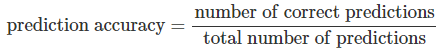

**Randomness and Seeds**

- Randomness is used when we need to make a decision in our analysis that needs to be fair, unbiased, and not influenced by human input.
- The use of randomness however make it hard to reproduce data.
- The trick is to use a random number generator that produces a sequence of numbers that are completely determined by a seed value. Once a seed is set, everything after that point may look random, but is actually totally reproducible.

**Train / Test Split**

- Training set is usually 50 to 95% and testing set is between 5 to 50%.
  - How much to divide the data between the training and testing set is weighing the trade off between training and accurate model and getting an accurate evaluation of its performance.
- Splitting the data set:
   - I. Shuffles the data before splitting, ensuring that any ordering present in the data does not influence the data that ends up in the training and testing sets.
   - II. Stratifies the data by the class label, ensuring that roughly the same proportion of each class ends up in both the training and testing sets.
   
**Critically Analyze Performance**

- Its important not only to look at accuracy but also the confusion matrix. For example, it might be very bad for the classifier to predict "benign" when the true class is "malignant."
- The baseline to compare the accuracy of your classifier: the majority classifier.

**Cross Validation**

- If we just split our overall training data once, the best parameter choice will depend strongly on whatever data was lucky enough to end up in the validation set. Using multiple different train/validation splits, we'll get a better estimate of accuracy, which will lead to a better choice of the number of neighbors K for the overall set of training data.
- In cross-validation, we split our overall training data into C evenly sized chunks. Then, iteratively use 1 chunk as the validation set and combine the remaining C - 1 chunks as the training set.
- Typically more folds we use, the better our accuracy estimate will be. However we are limited by computational power.
  - You need to consider the size of the data, the speed of the algorithm and the speed of your computer.
  - Typically C is chosen to be either 5 or 10.
  
**Under/Overfitting**

- Underfitting occurs as we increase the number of neighbors. 
  - Causes a sort of "averaging effect" where if K = number of data points, then we would only predict the majority class.
  - If the model isn't influenced enough by the training data, it is said to underfit the data.
- Overfitting occurs if we use too little numbers of neighbors.
  - The classifier is essentially just matching eah new observation to its closest neighbor in the training set.
  - If the model is influenced too much by the training data, it is said to overfit the data.

In [ ]:
Classification With Training Sets

# Data split

cancer_split <- initial_split(cancer, prop = 0.75, strata = Class)
cancer_train <- training(cancer_split)
cancer_test <- testing(cancer_split)

# Computing the Accuracy

cancer_test_predictions <- predict(knn_fit, cancer_test) |>
    bind_cols(cancer_test) |> 
    metrics(truth = Class, estimate = .pred_class) |>
    filter(.metric == "accuracy")

# Confusion Matrix

confusion <- cancer_test_predictions |>
    conf_mat(truth = Class, estimate = .pred_class)

# Cross Validation just varying vfolds.

cancer_vfold <- vfold_cv(cancer_train, v = 5, strata = Class) ;5 here can be changed, this code to see how accuracy changes with # of vfolds.

cancer_recipe <- recipe(Class ~ Smoothness + Concavity, data = cancer_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
    set_engine("kknn") |>
    set_mode("classification")

fold_knn_fit <- workflow() |>
    add_recipe(cancer_recipe) |>
    add_model(knn_spec) |>
    fit_resample(resamples = cancer_vfold)

vfold_metrics_50 <- cv_knn_fit |>
    collect_metrics() |>
    filter(.metric == "accuracy")

# Choosing K with specific vfold.

knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>  ;neighbors is tune(), not a value
    set_engine("kknn") |>
    set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

knn_fit <- workflow() |>
    add_recipe(cancer_recipe) |>
    add_model(knn_spec_2) |>
    tune_grid(resamples = cancer_vfold, grid = k_vals) ;notice we dont use fit or fit_resamples here. cancer_vfold is reused from above. 

knn_results <- knn_fit |>
    collect_metrics() |>
    filter(.metric == "accuracy")

# Plotting K vs. Accuracy

accuracy_vs_k <- ggplot(knn_results, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 12))

## Chapter 7

- Regression the goal is to predict numerical values instead of categorical values.
  - ex. Number of hours a person spends on exercise each week to predict their race time in the annual Boston marathon.
  - Trick to tell if a variable is numerical or categorical: take two response variables X and Y from your data, and ask, "is reponse variable X more than response Y?" If the variable is categorical, the question will make no sense.
  
**K-Nearest Neighbors Regression Algorithm**

- Strength:
  - Works well with non-linear relationships. This stems from using NN to predict values. The algorithm really has very few assumptions about what the data must look like for it to work.
  
**Training, Evaluating, and Tuning the Model**

- We cannot use accuracy to see how well our predictions matched the true labels, this is because our predictions will almost never EXACTLY match the true response variable values. Instead root mean square prediction error (RMSPE) is employed.
  - We square the difference; we want to add up the errors, so we want to make sure that we are only adding up positive values, with larger positive values representing larger mistakes.
  - Predictions are close to true values: RMPSE will be small.
- When we use cross validation, we choose the K that gives us the smallest RMSPE.
- RMSE - calculating prediction error on the training data (in-sample prediction)
- RMPSE - predicting and evaluating prediction quality on the testing or validation data

**Underfitting and Overfitting**

- When K values are small:
  - Overfitting occurs and the line follows the training data quite closely.
- When K values are large:
  - Underfitting occurs and the blue line becomes smooth.
  - If the blueline becomes flat, then K is equal to the number of datapoints in the training set. We would just be getting mean of the "Y" variable.
  
**Strengths and Limitations of KNN Regression**

- Strengths
  - I. Is a simple, intuitive algorithm,
  - II. requires few assumptions about what the data must look like, and
  - III. works well with non-linear relationships (i.e., if the relationship is not a straight line).
- Weaknesses
  - I. Becomes very slow as the training data gets larger,
  - II. may not perform well with a large number of predictors, and
  - III. may not predict well beyond the range of values input in your training data.

### Function List

`scale_y_continuous` - formats teh axis labels to put dollar signs in y-axis.
  - ex. scale_y_continuous(labels = dollar_format())

`slice_sample` - takes small random sample.
  - ex. small_sacramento <- slice_sample(sacramento, n = 30) ;took 30 samples.

In [1]:
Regression Using KNN

# Packages, Loading Data into R
library(tidyverse)
library(tidymodels)
library(gridExtra)

set.seed(5)

sacramento <- read_csv("data/sacramento.csv")

# Training Split

sacramento_split <- initial_split(sacramento, prop = 0.75, strata = price)
sacramento_train <- training(sacramento_split)
sacramento_test <- testing(sacramento_split)

# Recipe

sacr_recipe <- recipe(price ~ sqft, data = sacramento_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

sacr_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

sacr_wkflow <- workflow() |>
    add_recipe(sacr_recipe) |>
    add_model(sacr_spec)

# Cross Validation

sacr_vfold <- vfold_cv(sacramento_train, v = 5, strata = price)
gridvals <- tibble(neighbors = seq(from = 1, to = 200, by = 3))

sacr_results <- sacr_wkflw |>
    tune_grid(resamples = sacr_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metrics == "rmse")

# Show only the row of minimum RMPSE

sacr_min <- sacr_results |>
    filter(mean == min(mean))

# Evaluating on the Test Set

kmin <- scar_min |> pull(neighbors)

sacr_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
    set_engine("kknn") |>
    set_mode("regression")

sacr_fit <- workflow() |>
    add_recipe(sacr_recipe) |>
    add_model(sacr_spec) |>
    fit(data = sacramento_train)

sacr_summary <- sacr_fit |>
    predict(sacramento_test) |>
    bind_cols(sacramento_test) |>
    metrics(truth = price, estimate = .pred) |>
    filter(.metric == 'rmse')

# Plotting

sacr_preds <- tibble(sqft = seq(from = 500, to = 5000, by = 10))

sacr_preds <- sacr_fit |>
    predict(sacr_preds) |>
    bind_cols(sacr_preds)

plot_final <- ggplot(sacramento_train, aes(x = sqft, y = price)) +
    geom_point(alpha = 0.4) +
    geom_line(data = sacr_preds, mapping = aes(x = sqft, y = .pred), color = "blue") +
    xlab("House size (square feet)") +
    ylab("Price (USD)") +
    scale_y_continuous(labels = dollar_format()) +
    ggtitle(paste0("K = ", kmin)) +
    theme(text = element_text(size = 12))

ERROR: Error in parse(text = x, srcfile = src): <text>:1:12: unexpected symbol
1: Regression Using
               ^


 ## CHAPTER 8
 
 - Linear regression address both limitations of KNN regression:
   - Does not predict well beyond the range of the predictors.
   - Method gets significantly slower as the training data set grows.
   
 - Equation for the straight line:

     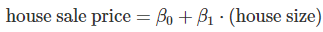
 
 - Simple linear regression chooses the straight line of best fit by minimizing the average squared vertical distance between itself and each of the observed data points in the training data.
 - Note, we do not standardize our predictors! In linear regression, standardization does not affect the FIT, but it does affect the COEFFICIENTS in the equation!
 
**Comparing Simple Linear and KNN Regression**
 
 - Advantage of linear regression:
   - The intercept tells us what the prediction is when all of the predictors are equal to 0.
   - Slope tells us what unit increase in the target/response variable we predict given a unit increase in the predictor variable.
 - Disadvantage of linear regression
   - Not useful when relationship between the target and the predictor is not linear, but instead some other shape. Using KNN regression might be better in those cases.

- How did these two models compare? We would look at the RMPSE value and use the model with the lower value.
- For extrapolation (predicting outside the range of the observed data):
  - Linear regression have constant slopes and KNN regression have flat slopes.
  - Depending on the application, the flat or constant slope trent may make more sense.
  
**Multivariable Linear Regression**

- We do not need to use cross-validation to choose any parameters, nor do we need to standardize.

**Multicollinearity and Outliers**

- Outliers
  - The problem with outlier is that they can have too much influence on the line of best fit.
  - Fortunately, if you have enough data, the inclusion of one or two outliers--as long as their values are not too wild--will typically not have large effect on the line of best fit.
- Multicollinearity
  - Occurs when you include multiple predictors that are strongly linearly related to one another.
  - The coefficients that describe the plane of best fit can be very unreliable--small changes to the data can result in large changes in the coefficients.
  
**Designing New Predictors**

- Take two variables x and y that have a non-linear relationship. It might be necessary to mutate one of the variable to "linearize" the relationship.

In [ ]:
Linear Regression in R

# Creating the Recipe

lm_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode("regression")

lm_recipe <- recipe(price ~ sqft, data = sacramento_train)

lm_fit <- workflow() |>
    add_recipe(lm_recipe) |>
    add_model(lm_spec) |>
    fit(data = sacramento_train)

# Results

lm_test_results <- lm_fit |>
    predict(sacramento_test) |>
    bind_cols(sacramento_test) |>
    metrics(truth = price, estimate = .pred)

# Plotting the Line

lm_plot_final <- ggplot(sacramento_train, aes(x = sqft, y = price)) +
    geom_point(alpha = 0.4) +
    xlab("House size (sqaure feet)") +
    ylab("Price (USD)") +
    scale_y_continuous(labels = dollar_format()) +
    geom_smooth(method = "lm", se = FALSE) +
    theme(text = element_text(size = 12))

# Extracting Coefficients

coeffs <- lm_fit |>
    pull_workflow_fit() |>
    tidy()                  ;converts the result into a dataframe.